In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd ..

/content/drive/My Drive


In [ ]:
cd content/drive/MyDrive/MedIx\ REU/Datasets

[Errno 2] No such file or directory: 'content/drive/MyDrive/MedIx REU/Datasets'
/content/drive/My Drive


In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf
import numpy as np  # linear alg
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples, homogeneity_completeness_v_measure
from sklearn.preprocessing import normalize, MinMaxScaler
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import os
from os import path
#from s_dbw import S_Dbw, SD

In [ ]:
##### Import Trained Model #####
model = keras.models.load_model("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Autoencoder/enc_VAE_my_model_299" , compile = True)

In [ ]:
model.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 72, 72, 1)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 72, 72, 32)   320         ['input_layer[0][0]']            
                                                                                                  
 bn_1 (BatchNormalization)      (None, 72, 72, 32)   128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 72, 72, 32)   0           ['bn_1[0][0]']                   
                                                                                            

In [ ]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="flatten").output)
feature_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 72, 72, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 72, 72, 32)        320       
                                                                 
 bn_1 (BatchNormalization)   (None, 72, 72, 32)        128       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 72, 72, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 36, 36, 64)        18496     
                                                                 
 bn_2 (BatchNormalization)   (None, 36, 36, 64)        256       
                                                                 
 lrelu_2 (LeakyReLU)         (None, 36, 36, 64)        0   

In [ ]:
# pre set parameters
colors = ['#1f77b4', '#ff7f0e', '#a52a2a','#2ca02c',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf', '#2cb49b', '#1ae700', '#711d7a', '#ff4d82','#2700ea']
radio_colors_mnist = ['#2a72a5','#ffb732','#6db6ac', '#6ba10c']
#radio_colors = ['#9e2020', '#d9920f', '#6d9fb6', '#568208'] #lighter colors...
radio_colors = ['#e81005', '#f7c00a', '#364acf', '#568208']
#['#048a94','#b81c07', '#100494','#cfd1d1']


In [ ]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [ ]:
def getSamePadding(this_array):
    # Array to be added as row
    row_to_be_added = this_array[70]
    # Adding row to numpy array
    result = np.vstack ((this_array, row_to_be_added) )

    # Array to be added as column
    column = this_array[:, 70]
    last_item = this_array[70, 70]

    # Adding column to numpy array
    column_to_be_added = np.append(column, last_item)

    # stack column to numpy array
    new_img = np.column_stack((result, column_to_be_added))
    return new_img

In [ ]:
total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Autoencoder/mal_files/Agreement_Binary_Rating.csv")
total_nod = total['noduleID']
total_nod = np.array(total_nod)

image_folder = '/content/drive/MyDrive/MedIx REU/Datasets/Amal/images_1332'
train_images = []
train_noduleId = []
print(image_folder)

for dir1 in os.listdir(image_folder):
    print(dir1)
    if not dir1.startswith('.'):
        for file in os.listdir(os.path.join(image_folder, dir1)):
            #print(file)
            noduleID = file.split('.')[0]
            if not file.startswith('.'):
                noduleID = int(noduleID)
                train_noduleId.append(noduleID)
                temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                temp_image = getNormed(temp_image)
                enlarged_img = getSamePadding(temp_image)
                train_images.append(enlarged_img)

/content/drive/MyDrive/MedIx REU/Datasets/Amal/images_1332
Malignancy_5
Malignancy_1
Malignancy_4
Malignancy_2
Malignancy_3


In [ ]:
tr_df = pd.DataFrame(train_noduleId,columns =['noduleID'])
print(tr_df)

      noduleID
0          324
1         1888
2         1606
3         1427
4         1760
...        ...
1327      2301
1328      2583
1329      1772
1330       231
1331      2540

[1332 rows x 1 columns]


In [ ]:
train_slices = pd.merge(tr_df, total)
display(train_slices)

,noduleID,InstanceID,RadiologistID,imageZposition,Area,ConvexArea,Malignancy_1,Malignancy_2,Malignancy_3,Malignancy_4,Malignancy,Binary Rating,Binary_Rating_name,Agreement
0,324,4732,3,-273.000000,488,520,5,5,5,4,5,1,Malignant,2
1,1888,28743,4,-95.500000,705,911,3,5,5,2,5,3,Unknown,1
2,1606,24119,2,-500.299988,172,180,5,4,5,2,5,3,Unknown,1
3,1427,21366,2,-420.100006,428,449,5,5,3,3,4,3,Unknown,1
4,1760,26447,4,-83.250000,461,481,5,5,3,4,5,3,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,2301,35200,4,-175.110001,93,103,3,4,1,3,3,3,Unknown,1
1328,2583,39596,3,-144.029999,64,64,3,3,3,0,3,2,Undetermain,2
1329,1772,26626,3,-205.600000,126,133,4,3,3,3,3,2,Undetermain,2
1330,231,3308,3,1366.500000,162,167,5,2,3,3,3,3,Unknown,1


In [ ]:
##### Run all data (testing, training, and validation) to retrieve embeddings and plot tsne #####                               USE THIS ONE! :)
# read in file with all of the data

#total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Autoencoder/spic_files/1332_images_72X72.csv")
#total_ids = total['InstanceID']
#total_ids = np.array(total_ids)

#total_images = total.drop(['InstanceID','Binary_Rating_Spic'], axis=1)
total_data = np.array(train_images).reshape(-1,72,72,1)
#print(total_data.shape)

# get the embeddings
#total_embeddings_before = model.predict(total_data)
#print(total_embeddings_before[0])
#total_embeddings2 = (total_embeddings_before[0] - total_embeddings_before[0].min()) / (total_embeddings_before[0].max() - total_embeddings_before[0].min())

total_embeddings_before = feature_extractor.predict(total_data)
total_embeddings2 = (total_embeddings_before - total_embeddings_before.min()) / (total_embeddings_before.max() - total_embeddings_before.min())
tot_embedded2 = TSNE(n_components=2,random_state=2).fit_transform(total_embeddings2)

42/42 [==============================] - 0s 4ms/step


In [ ]:
np.any(np.isnan(total_embeddings2))

False

(array([-50., -40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, -50.0, '−50'),
  Text(0, -40.0, '−40'),
  Text(0, -30.0, '−30'),
  Text(0, -20.0, '−20'),
  Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40')])

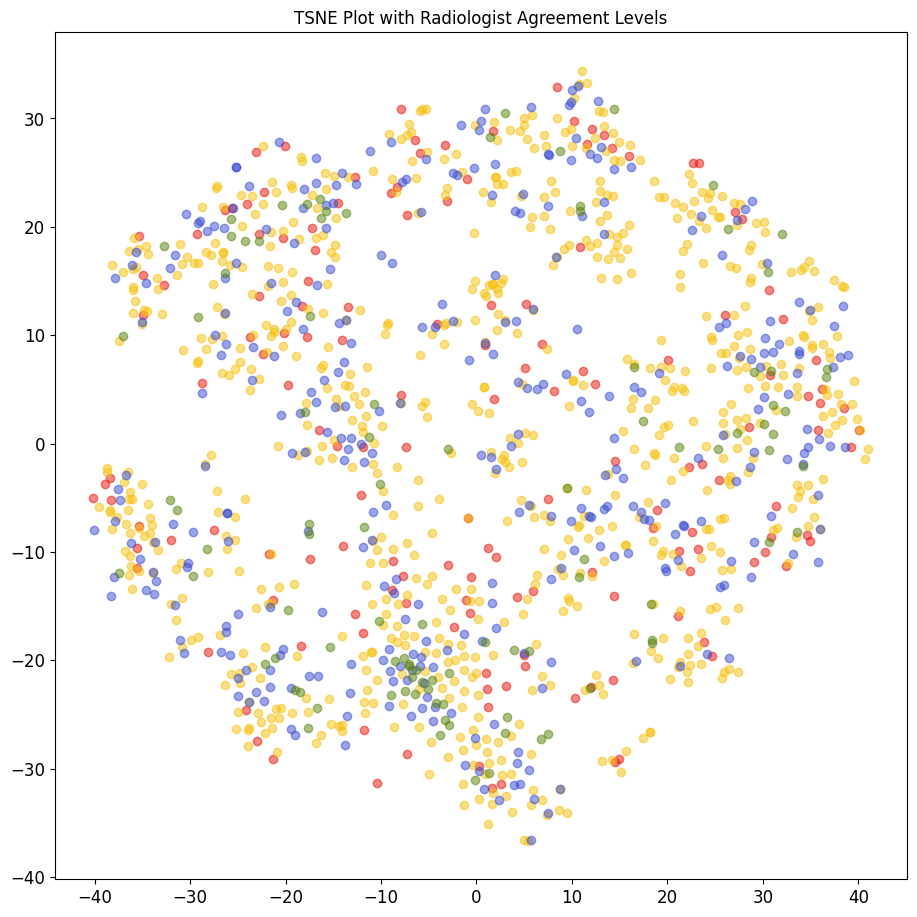

In [ ]:
## plotting the tsne with varying levels of radiologist disagreement
total_ids = train_slices['InstanceID'] #pandas dataframe
radio_ids2 = total_ids.values #list
agreements = train_slices['Agreement']
tsne_radio = plt.figure(figsize=(11,11))
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']

agreement_inds = []
agreement_id = []

for i in radio_classes:
  inds = np.where(agreements==i)
  plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=radio_colors[i])
  ids = radio_ids2[inds]
  agreement_inds.append(inds)  # should be in the order of high agreement -> low agreement  # also, these are the index numbers
  agreement_id.append(ids)  # these are the instance id's
plt.title('TSNE Plot with Radiologist Agreement Levels')                                                                       # commented out title
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#name5 = 'test case {}/tsne/radiologist tsne'.format(run)

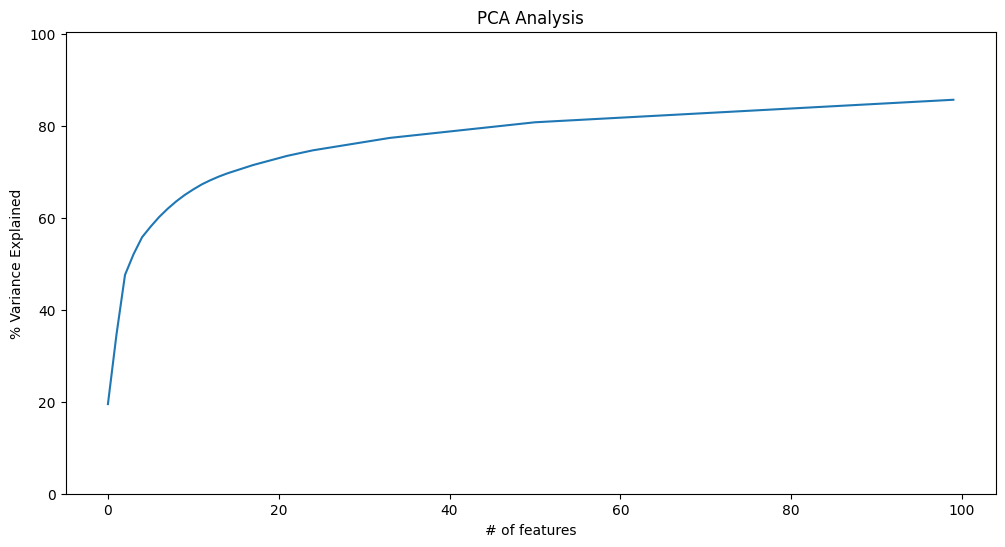

In [ ]:
pca = PCA(n_components=100)
pca.fit(total_embeddings2)
variance = pca.explained_variance_ratio_

var = np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)

plt.plot(var)

In [ ]:
pca = PCA(n_components=20)
pca_scale = pca.fit_transform(total_embeddings2)

In [ ]:
##### Run spectral clustering on the embeddings for ALL of the data #####
numbers = [5] #[2, 3, 4, 5, 6] #number of clusters
silhouette_total = []
wss_total = []

embeddings = total_embeddings2 #change depending on if we wanna run test cases vs all cases
X_embedded = tot_embedded2 #change depending on if we wanna run test cases vs all cases
#sc = SpectralClustering(n_clusters=numbers[0], random_state=0, affinity= 'nearest_neighbors',)
#sc = KMeans(n_clusters=numbers[0], random_state=0) , “elkan”
#sc = KMeans(n_clusters=numbers[0], random_state=20, algorithm = 'elkan', max_iter = 10)
#sc = GaussianMixture(n_components=numbers[0],random_state=0)
sc = AgglomerativeClustering(n_clusters=numbers[0], affinity= 'euclidean')
#y_sc = sc.fit_predict(embeddings)

y_sc = sc.fit_predict(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


{0: 494, 1: 206, 2: 250, 3: 222, 4: 160}


<ipython-input-78-7f86371abd72>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'id':radio_ids2[i],'cluster':c}, ignore_index=True)
<ipython-input-78-7f86371abd72>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'id':radio_ids2[i],'cluster':c}, ignore_index=True)
<ipython-input-78-7f86371abd72>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'id':radio_ids2[i],'cluster':c}, ignore_index=True)
<ipython-input-78-7f86371abd72>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'id':radio_ids2[i],'cluster':c}, ignore_index=True)
<ipython-input-78-7f86371abd72>:14: FutureWa

Text(0.5, 1.0, 'Hierarchical Clustering TSNE With 5 Clusters')

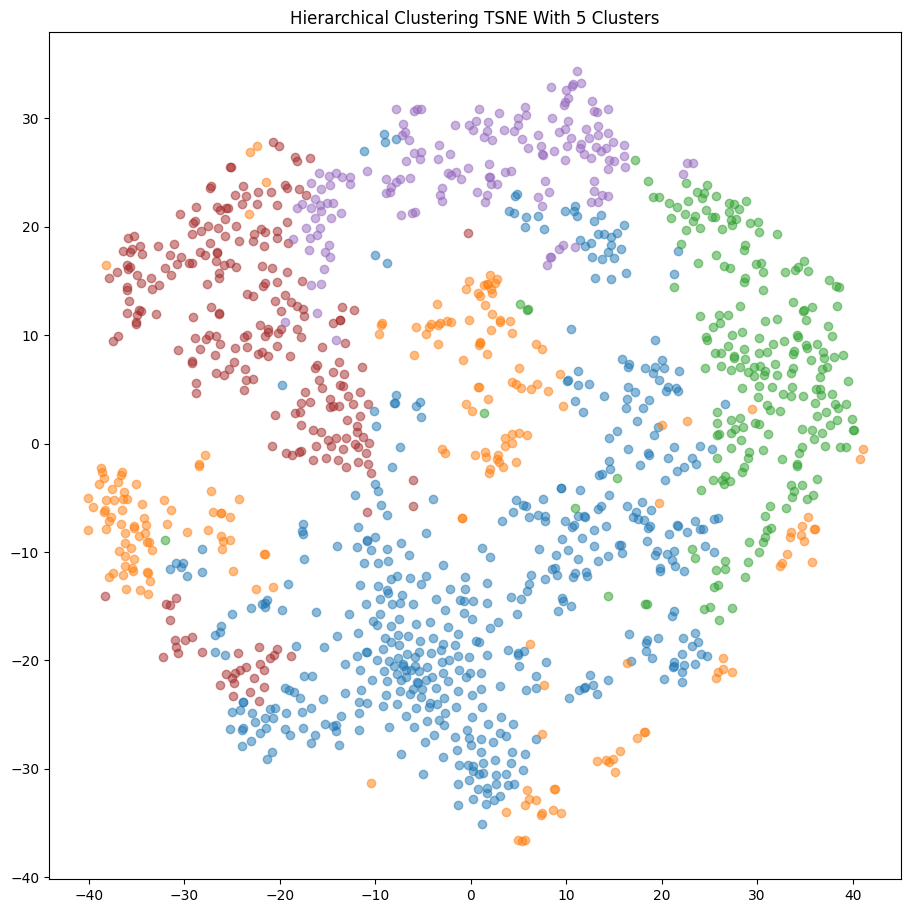

In [ ]:
#Conunt how many instances in each cluster
unique, counts = np.unique(y_sc, return_counts=True)
print(dict(zip(unique, counts)))
#plot the tsne with spectral clusters
og_spectral = plt.figure(figsize=(11,11))
m1=[]
df = pd.DataFrame(columns=['id','cluster'])
for c in range(0,5):
    inds = np.where(y_sc==c)[0]
    #print(len(inds))
    #m1.append(inds)
    for i in inds:
      #print(radio_ids2[i])
      df = df.append({'id':radio_ids2[i],'cluster':c}, ignore_index=True)
    plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[c])

plt.title('Hierarchical Clustering TSNE With {} Clusters'.format(numbers[0]))

In [ ]:
df.to_csv('/content/drive/MyDrive/MedIx REU/Datasets/Amal/Autoencoder/m4_HC.csv')

In [ ]:
##### Run spectral clustering on the embeddings for ALL of the data #####
'''
numbers = [2] #[2, 3, 4, 5, 6] #number of clusters
silhouette_total = []
wss_total = []
spic_legend_Cls = ['Spiculated','Not Spiculated']
for numclusters in numbers:
  embeddings = total_embeddings2 #change depending on if we wanna run test cases vs all cases
  X_embedded = tot_embedded2 #change depending on if we wanna run test cases vs all cases
  sc = SpectralClustering(n_clusters=numclusters, random_state=0)
  y_sc = sc.fit_predict(embeddings)
  #Conunt how many instances in each cluster
  unique, counts = np.unique(y_sc, return_counts=True)
  print(dict(zip(unique, counts)))
  # plot the tsne with spectral clusters
  og_spectral = plt.figure(figsize=(11,11))
  for i in range(numclusters):
      inds = np.where(y_sc==i)[0]
      plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])
  name3 = 'test case {}/{} cluster/spectral tsne'.format(run, numclusters)
  plt.title('Spectral Clustering TSNE With {} Clusters'.format(numclusters))
'''

"\nnumbers = [2] #[2, 3, 4, 5, 6] #number of clusters\nsilhouette_total = []\nwss_total = []\nspic_legend_Cls = ['Spiculated','Not Spiculated']\nfor numclusters in numbers:\n  embeddings = total_embeddings2 #change depending on if we wanna run test cases vs all cases\n  X_embedded = tot_embedded2 #change depending on if we wanna run test cases vs all cases\n  sc = SpectralClustering(n_clusters=numclusters, random_state=0) \n  y_sc = sc.fit_predict(embeddings)\n  #Conunt how many instances in each cluster\n  unique, counts = np.unique(y_sc, return_counts=True)\n  print(dict(zip(unique, counts)))\n  # plot the tsne with spectral clusters\n  og_spectral = plt.figure(figsize=(11,11))\n  for i in range(numclusters):\n      inds = np.where(y_sc==i)[0]\n      plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])\n  name3 = 'test case {}/{} cluster/spectral tsne'.format(run, numclusters)\n  plt.title('Spectral Clustering TSNE With {} Clusters'.format(numclusters))\n"